# Rail Track Anomaly Detection Using Two-Model Solution
Author: Lwam Teklay

This notebook presents a comprehensive solution for detecting anomalies on rail tracks employing a two-stage model architecture. The approach involves leveraging a U-Net model for precise segmentation of regions of interest, followed by a classification model to identify anomalies within these segmented areas.

The dataset utilized in this project comprises images of rail tracks along with their corresponding masks, facilitating supervised learning for model training and evaluation. Through the combined utilization of advanced deep learning techniques, this solution aims to enhance rail track maintenance and safety protocols by enabling automated anomaly detection.

# U-Net Model for Rail Track Segmentation


## Step 1: Importing Libraries


Libraries like NumPy, OpenCV, TensorFlow, etc., are essential for data manipulation, image processing, and neural network creation.

In [ ]:
import numpy as np
import cv2
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from pathlib import Path



## Step 2: Uploading and Reading Dataset, and Creating Masks from JSON Data

In this step, we'll upload the dataset, consisting of images and corresponding JSON files containing mask annotations, from OneDrive. We'll then proceed to read the JSON files to extract the necessary mask data.

First, let's read the image data and create masks based on the coordinates provided in the JSON files. The dataset, exported via Roboflow, includes 1971 images annotated in COCO Segmentation format. Each image has undergone pre-processing, including auto-orientation, resizing to 640x640, and auto-contrast adjustment via adaptive equalization. Additionally, data augmentation techniques have been applied to enhance dataset diversity, including horizontal flips, random rotations (-15 to +15 degrees), and brightness adjustments (-15% to +15%).

We'll leverage this annotated dataset to train our models for rail track anomaly detection.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Next, we focus on preparing the data for a machine learning task, specifically image segmentation using neural networks. The objective is to accurately identify and mask rail tracks within the images.

In [ ]:
# This function loads a JSON file that contains annotations for images
def load_coco_json(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    return data


 #This functin creates a binary mask from polygon annotations
def create_mask(height, width, polygons):
    mask = np.zeros((height, width), dtype=np.uint8)
    for polygon in polygons:
        np_polygon = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
        cv2.fillPoly(mask, [np_polygon], 1)
    return mask



#This function processes the image data and associates them with their masks
def process_data(data, base_dir, img_size=(128, 128)):
    images = []
    masks = []

    for img_info in data['images']:
        img_path = os.path.join(base_dir, img_info['file_name'])
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img_id = img_info['id']
        img_annotations = [ann for ann in data['annotations'] if ann['image_id'] == img_id]

        if img_annotations:
            mask = create_mask(img_info['height'], img_info['width'], img_annotations[0]['segmentation'])
            mask = cv2.resize(mask, img_size)
            mask = np.expand_dims(mask, axis=-1)
            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)


#The loaded functions are then used to load and process the training, validation, and test data.

# Load the JSON annotations for training, validation, and test datasets.
train_data = load_coco_json('/content/drive/My Drive/datasetV3/train/_annotations.coco.json')
valid_data = load_coco_json('/content/drive/My Drive/datasetV3/valid/_annotations.coco.json')
test_data = load_coco_json('/content/drive/My Drive/datasetV3/test/_annotations.coco.json')

# Define directory paths
train_dir = '/content/drive/My Drive/datasetV3/train'
valid_dir = '/content/drive/My Drive/datasetV3/valid'
test_dir = '/content/drive/My Drive/datasetV3/test'

# Process the images and annotations to create the datasets for training, validation, and testing.
train_images, train_masks = process_data(train_data, train_dir)
valid_images, valid_masks = process_data(valid_data, valid_dir)
test_images, test_masks = process_data(test_data, test_dir)

## Step 3: Loading Data
Convert loaded images and their corresponding masks into a TensorFlow Dataset.

In this step, we convert the loaded images and their corresponding masks into TensorFlow Datasets. These datasets, comprising training, validation, and test sets, are now prepared for utilization in the training and evaluation of our model.

By making use of TensorFlow's data handling methods, we ensure efficient management and processing of the data throughout the model training and evaluation phases. The utilization of 'tf.data.Dataset' not only streamlines the data pipeline but also facilitates additional optimizations such as batching, shuffling, and prefetching. These optimizations are important for enhancing the effectiveness and efficiency of model training, particularly when dealing with large datasets.


In [ ]:
# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_masks))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))

In [ ]:
# Get the size of each dataset
train_dataset_size = len(train_dataset)
valid_dataset_size = len(valid_dataset)
test_dataset_size = len(test_dataset)

# Print the sizes
print(f"Training Dataset Size: {train_dataset_size}")
print(f"Validation Dataset Size: {valid_dataset_size}")
print(f"Test Dataset Size: {test_dataset_size}")


Training Dataset Size: 1724
Validation Dataset Size: 152
Test Dataset Size: 80


## Step 4: Preparing Datasets
Batch the training, validation, and testing sets for the training process. Basically, configure the TensorFlow datasets we created earlier (for training, validation, and testing) to further prepare them for input into the neural network model.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)# AUTOTUNE allows TensorFlow to automatically tune the prefetch buffer size based on runtime conditions.

#we batch the entire validation and test datasets as they are since they're small in size
validation_batches = valid_dataset.batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

In [ ]:
print(test_batches)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>


The following section of code defines a function for displaying images and their corresponding masks and then uses it to display a random sample from the training batches. Randomly selecting and displaying a sample image and its corresponding true mask from the training dataset. This can be especially helpful for verifying the data processing pipeline and understanding the nature of the training data.

In [ ]:
def display(display_list):
  #sets up a matplotlib figure with a specified size (15x15 inches)
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

 #retrieves the first batch from 'train_batches'
sample_batch = next(iter(train_batches))
#generates a random index within the range of the batch size
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

The following function we defined is a key component of building convolutional neural networks, particularly in architectures like U-Net. This function creates a sequence of two convolutional layers, each followed by a ReLU activation. We're applying two convolutional layers in sequence. The output of the first layer is fed as the input to the second layer.

In summary, the following function is a building block for convolutional neural networks, encapsulating a commonly used pattern of two consecutive convolutional layers, each with ReLU activation. Good for writing clean, modular, and reusable code for neural network construction.


In [ ]:
def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

The following function is another important component in building neural networks, particularly for architectures used in image segmentation tasks like U-Net. This function combines the concept of a convolutional block with downsampling.

Max pooling is used for downsampling, reducing the spatial dimensions (width and height) of the input feature map by half. This operation helps to reduce the computation required in deeper layers and also provides some level of translation invariance.


The 'downsample_block' function is typically used in the encoder (downsampling) path of U-Net-like architectures.
It serves to progressively reduce the spatial dimensions of the input while increasing the depth (number of channels) to allow the network to learn increasingly abstract representations of the input data.
The function returns both the output before pooling ('f') and after pooling and dropout ('p') because, in architectures like U-Net, the feature maps before downsampling ('f') are often used later in the network for skip connections to the upsampling path.


In summary, this function encapsulates the operations of convolution, downsampling, and regularization, which are key steps in the encoder part of segmentation networks.

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

The following function is crucial for constructing the decoder (or upsampling) path of a U-Net architecture. This function performs the inverse operation of the previously defined 'downsample_block', effectively increasing the spatial dimensions of the feature maps.

The function gradually increases the spatial resolution of the feature maps, allowing the network to construct a detailed segmentation map.

The use of skip connections (concatenation with 'conv_features') helps the network recover spatial information lost during downsampling, which is crucial for accurate localization in segmentation tasks.

In [ ]:

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

## Step 5: Building the U-Net Model

Here, we define and build our U-Net model, which is a convolutional network architecture for fast and precise segmentation.

In [ ]:

def build_unet_model():
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

## Step 6: Compiling and Training the Model

The model is compiled, and then it is trained on the training dataset while validating on the validation dataset.

In [ ]:

unet_model = build_unet_model()

In [ ]:

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [ ]:

NUM_EPOCHS = 8
TRAIN_LENGTH = len(train_images)  # the total number of training images
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
VAL_LENGTH = len(valid_images)  # the total number of validation images
VALIDATION_STEPS = VAL_LENGTH // BATCH_SIZE

model_history = unet_model.fit(
    train_batches,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=validation_batches,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)


Epoch 1/15
26/26 [==============================] - 80s 1s/step - loss: 18.3224 - accuracy: 0.7637 - val_loss: 0.6825 - val_accuracy: 0.7870
Epoch 2/15
26/26 [==============================] - 65s 976ms/step - loss: 0.6268 - accuracy: 0.7874 - val_loss: 0.4086 - val_accuracy: 0.8607
Epoch 3/15
26/26 [==============================] - 25s 976ms/step - loss: 0.3648 - accuracy: 0.8651 - val_loss: 0.3087 - val_accuracy: 0.8910
Epoch 4/15
26/26 [==============================] - 26s 994ms/step - loss: 0.2446 - accuracy: 0.9137 - val_loss: 0.2055 - val_accuracy: 0.9209
Epoch 5/15
26/26 [==============================] - 26s 988ms/step - loss: 0.1978 - accuracy: 0.9300 - val_loss: 0.1711 - val_accuracy: 0.9367
Epoch 6/15
26/26 [==============================] - 25s 980ms/step - loss: 0.1559 - accuracy: 0.9440 - val_loss: 0.1187 - val_accuracy: 0.9582
Epoch 7/15
26/26 [==============================] - 26s 984ms/step - loss: 0.1098 - accuracy: 0.9607 - val_loss: 0.1065 - val_accuracy: 0.9640
E

In [ ]:
unet_model.save('/content/drive/My Drive/RailTrackDataSet2/unet_model')

In [ ]:
#load the saved model
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/RailTrackDataSet2/unet_model')

## Step 7: Prediction and Visualization
Finally, we define functions for creating a mask from the model predictions and for displaying the predictions alongside the original.

In [ ]:

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
def show_predictions(dataset=None, num=1):
  if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])
count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

number of batches: 2


2/2 [==============================] - 0s 165ms/step


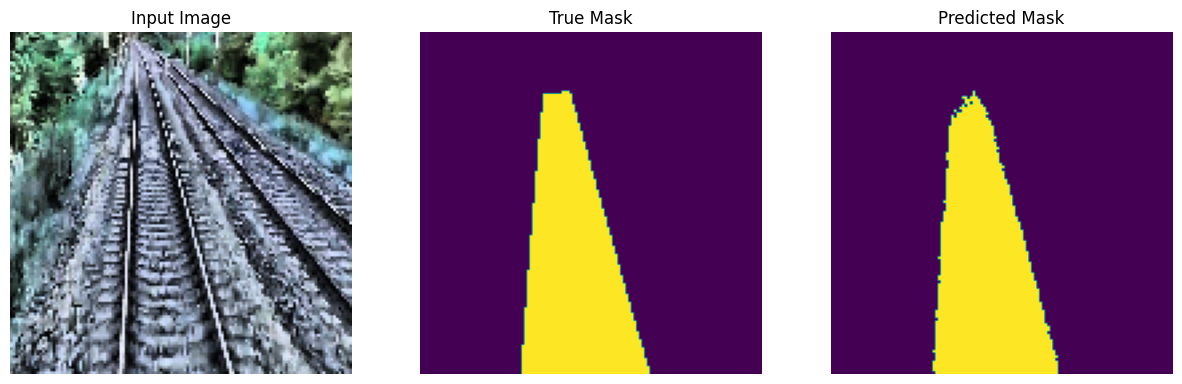

1/1 [==============================] - 0s 30ms/step


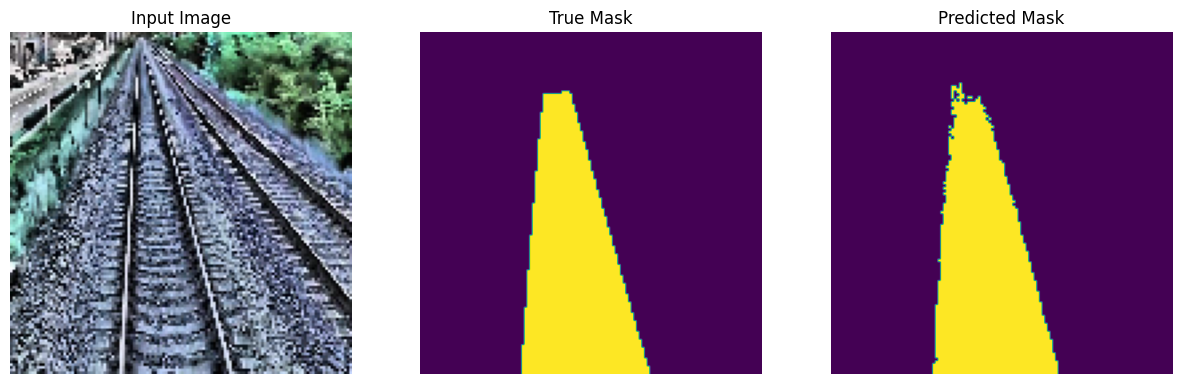

In [ ]:
show_predictions(test_batches, 2)

# Step 8: Conclusion

In this project, we presented a comprehensive solution for rail track anomaly detection employing a sophisticated two-model architecture. Our approach seamlessly integrates a U-Net model for precise segmentation of rail tracks with a classification model for anomaly identification, enhancing maintenance and safety protocols within railway infrastructure.

In this notebook, we documented the development steps of our U-Net model for rail track segmentation, a pivotal component in our comprehensive anomaly detection solution. Beginning with the annotation and preprocessing of our dataset, we ensured its readiness for training through augmentation techniques and efficient data handling with TensorFlow.

The heart of our methodology lies in the construction of the U-Net architecture, adeptly designed for precise segmentation tasks. By carefully orchestrating convolutional blocks and downsampling processes, we engineered a network capable of accurately delineating rail tracks within images. Leveraging skip connections and decoder blocks, we ensured the preservation of spatial information critical for detailed segmentation maps.

The model's performance was evaluated through validation techniques, affirming its efficiency in accurately segmenting rail tracks across diverse scenarios. By seamlessly integrating prediction and visualization functionalities, we provided insightful representations of our model's capabilities, facilitating both the validation and interpretation of results.

In conclusion, our approach to U-Net model development sets a solid foundation for automated rail track anomaly detection. As you delve into the subsequent notebook detailing the implementation of our classification model, you will witness the peak of our creative efforts in a comprehensive two-model solution aimed to revolutionize railway maintenance and safety standards.